# comparison of $R_{Q^2}$  and $R_{p_p}$  between the data and the GENIE samples
to extract $m_A$

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/acceptance/'

In [3]:
versions['data date'] = '2018_05_11'

In [4]:
OnBeam = pd.concat([pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_04_'+versions['data date']+'_vertices.csv')
                    ,pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['OnBeam']+'_05_'+versions['data date']+'_vertices.csv')])
OnBeamFV = sample_in_FV(OnBeam)
print "%d"%len(OnBeam)+' pairs from On-Beam, %d'%len(OnBeamFV)+' in Fiducial Volume'; print_line()

cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOnBeam,BeamOnNumbers = apply_cuts_to_data(OnBeamFV=OnBeamFV,cuts_order=cuts_order)
print 'applied cuts to data'
selected_events = reducedOnBeam['Pt & delta phi']
print len(selected_events),'selected pairs in data'

# tight FV
max_FV_y = 104 
min_FV_z,max_FV_z = 5,1020
min_FV_x,max_FV_x = 5,240
selected_events_tightFV = sample_in_FV(sample=selected_events
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
Nevents = len(selected_events_tightFV)
print Nevents,'selected pairs in data in tight FV'

38163 pairs from On-Beam, 24323 in Fiducial Volume
--------------------------------------------------------------
applied cuts to data
350 selected pairs in data
182 selected pairs in data in tight FV


# afro GENIE samples with different $m_A$

In [5]:
sns.set(style='white');
mA_array = [0.6,0.7,0.8,0.9,0.95,0.99,1.05,1.1,1.2,1.3,1.4] # S.Dytman: GENIE assumes mA=0.99 GeV/c2 (Dec-30,2017)
mA_colors= ['red','blue','forestgreen','purple','orange','pink','teal','yellow','black']

In [6]:
genie_CC1p0pi = dict()
for mA in mA_array:
    genie_sample = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/afro_genie_samples/CC_100k_mA_%.2f.csv'%mA)
    genie_CC1p0pi[mA] = genie_sample[genie_sample['IsCC_1p_200MeVc_0pi']==True]
    print len(genie_CC1p0pi[mA]),'CC1p0π events in GENIE samples with mA=%.2f'%mA

28507 CC1p0π events in GENIE samples with mA=0.60
30599 CC1p0π events in GENIE samples with mA=0.70
32163 CC1p0π events in GENIE samples with mA=0.80
33824 CC1p0π events in GENIE samples with mA=0.90
34543 CC1p0π events in GENIE samples with mA=0.95
34849 CC1p0π events in GENIE samples with mA=0.99
35749 CC1p0π events in GENIE samples with mA=1.05
36196 CC1p0π events in GENIE samples with mA=1.10
37239 CC1p0π events in GENIE samples with mA=1.20
38042 CC1p0π events in GENIE samples with mA=1.30
38810 CC1p0π events in GENIE samples with mA=1.40


In [17]:
# ----------------------------------------------------------
def find_x_poly(poly,y0,xmin=0,xmax=2):
    roots = (poly - y0).roots
    x_poly=-1
    for root in roots:
        if xmin<root and root<xmax:
            x_poly = root
    return x_poly
# ----------------------------------------------------------

# $R_{Q^2}$

In [124]:
def get_RQ2_GENIE(genie=None,Q2range=(0,0.4,1)
                  ,wvar = 'MicroBooNEWeight_Pmu_theta_Pp_theta'
                  ,debug=0):    
    hGenie,hGenie_err = np.zeros(2),np.zeros(2)
    for i in range(len(Q2range)-1):
        if debug: print 'Q2: min=%.2f,max=%.2f'%(Q2range[i],Q2range[i+1])
        genie_in_bin = genie[(genie['Q2']>Q2range[i])&(genie['Q2']<Q2range[i+1])]
        weights_in_bin = genie_in_bin[wvar]
        hGenie[i] = np.sum(weights_in_bin)
        hGenie_err[i] = np.sqrt(np.sum(np.square(weights_in_bin)))      
    R = hGenie[0]/hGenie[1]
    R_err = R*np.sqrt( np.square(hGenie_err[0]/hGenie[0]) + np.square(hGenie_err[1]/hGenie[1]) )
    return R,R_err

In [125]:
results = dict()
R_BeamOn,R_err_BeamOn = dict(),dict()
debug=0
Q2mid_array = [0.3]
for Q2mid in Q2mid_array:
    res = pd.DataFrame(columns=['R','R_err','mA'])
    Q2range=(0.1,Q2mid,0.6)
    # beam-on
    hBeamOn,hBeamOn_err = np.zeros(2),np.zeros(2)
    for i in range(len(Q2range)-1):
        events_in_bin = selected_events_tightFV[(selected_events_tightFV['reco_Q2']>Q2range[i])&(selected_events_tightFV['reco_Q2']<Q2range[i+1])]
        hBeamOn[i] = len(events_in_bin)
        hBeamOn_err[i] = np.sqrt(hBeamOn[i])
    if debug:
        print hBeamOn
        print hBeamOn_err
    R_BeamOn[Q2mid] = hBeamOn[0]/hBeamOn[1]
    R_err_BeamOn[Q2mid] = R_BeamOn[Q2mid]*np.sqrt( np.square(hBeamOn_err[0]/hBeamOn[0]) + np.square(hBeamOn_err[1]/hBeamOn[1]) )

    for mA in mA_array:
        R,R_err=get_RQ2_GENIE(genie=genie_CC1p0pi[mA],Q2range=Q2range,debug=debug)
        res = res.append(pd.DataFrame({'R':R,'R_err':R_err,'mA':mA}                                                              
                                          ,index=[mA]))
    results[Q2mid]=res
print 'done.'

done.


Beam on R,R_err: 1.47368421053 0.252893062584


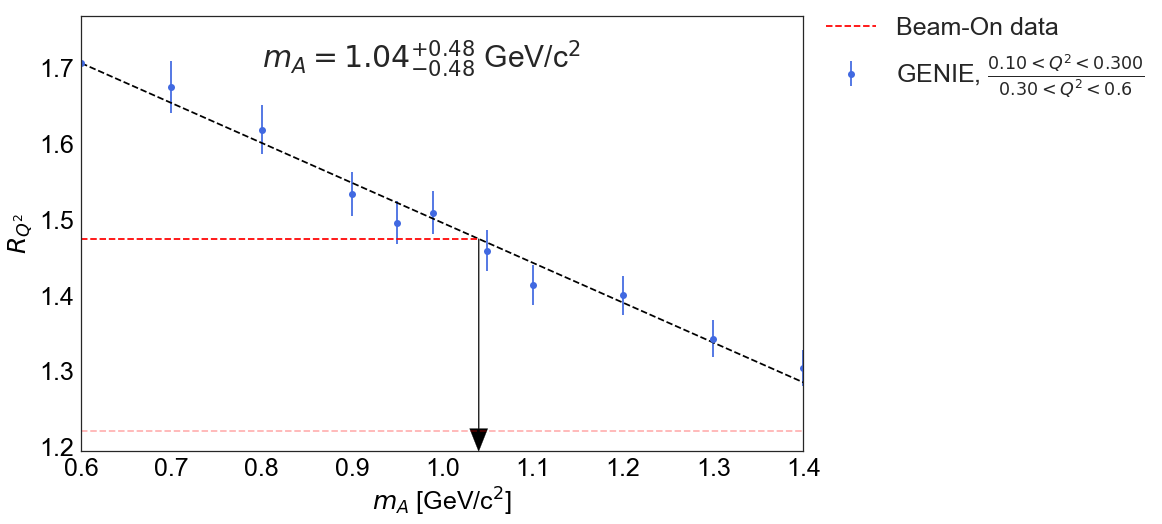

In [126]:
fig,ax=plt.subplots(figsize=(12.944,8))

for Q2mid,color in zip(Q2mid_array,mA_colors):
    res = results[Q2mid]
    plt.errorbar(x=res['mA'],y=res['R'],yerr=res['R_err'],color='royalblue',fmt='o'
                 ,label=(r'GENIE, $\frac{%.2f<Q^2<%.3f}{%.2f<Q^2<%.1f}$'%(0.1,Q2mid,Q2mid,0.6)))    
    
    x,y=res['mA'],res['R']
    z=np.polyfit(x,y,deg=1)
    poly=np.poly1d(z)
    x_poly=linspace(0.6,1.4,100)
    plt.plot(x_poly,poly(x_poly),'--',color='black')
    
    x_R_BeamOn = find_x_poly(poly,R_BeamOn[Q2mid])
    plt.plot([0.6,x_R_BeamOn],[R_BeamOn[Q2mid],R_BeamOn[Q2mid]],'--',color=color,label='Beam-On data')
    plt.arrow(x=x_R_BeamOn,y=poly(x_R_BeamOn),dx=0,dy=-0.25
              ,color='black',head_width=0.02,shape='full')

    print 'Beam on R,R_err:',R_BeamOn[Q2mid],R_err_BeamOn[Q2mid]
    x_R_BeamOn_dw = find_x_poly(poly,R_BeamOn[Q2mid]-R_err_BeamOn[Q2mid]); x_R_BeamOn_up_err = x_R_BeamOn_dw - x_R_BeamOn
    x_R_BeamOn_up = find_x_poly(poly,R_BeamOn[Q2mid]+R_err_BeamOn[Q2mid]); x_R_BeamOn_dw_err = x_R_BeamOn - x_R_BeamOn_up
    plt.plot([0.6,x_R_BeamOn_dw],[R_BeamOn[Q2mid]-R_err_BeamOn[Q2mid],R_BeamOn[Q2mid]-R_err_BeamOn[Q2mid]],'--'
             ,[0.6,x_R_BeamOn_up],[R_BeamOn[Q2mid]+R_err_BeamOn[Q2mid],R_BeamOn[Q2mid]+R_err_BeamOn[Q2mid]],'--'
             ,color=color,alpha=0.3)


set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$R_{Q^2}$',xlim=(0.6,1.4))
plt.text(0.8,1.7,r'$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_R_BeamOn,x_R_BeamOn_up_err,x_R_BeamOn_dw_err),fontsize=30)
plt.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

# $R_{p_p}$

In [76]:
def get_RPp_GENIE(genie=None,Pprange=None
                  ,wvar = 'MicroBooNEWeight_Pmu_theta_Pp_theta'
                  ,debug=0):    
    hGenie,hGenie_err = np.zeros(2),np.zeros(2)
    for i in range(len(Pprange)-1):
        if debug: print 'Pp: min=%.2f,max=%.2f'%(Pprange[i],Pprange[i+1])
        genie_in_bin = genie[(genie['Pp']>Pprange[i])&(genie['Pp']<Pprange[i+1])]
        weights_in_bin = genie_in_bin[wvar]
        hGenie[i] = np.sum(weights_in_bin)
        hGenie_err[i] = np.sqrt(np.sum(np.square(weights_in_bin)))      
    R = hGenie[0]/hGenie[1]
    R_err = R*np.sqrt( np.square(hGenie_err[0]/hGenie[0]) + np.square(hGenie_err[1]/hGenie[1]) )
    return R,R_err

In [113]:
results = dict()
R_BeamOn,R_err_BeamOn = dict(),dict()
debug=0
res = pd.DataFrame(columns=['R','R_err','mA'])
Ppmid = 0.55
Pprange=(0.3,Ppmid,0.75)
    # beam-on
hBeamOn,hBeamOn_err = np.zeros(2),np.zeros(2)
for i in range(len(Pprange)-1):
    events_in_bin = selected_events[(selected_events['reco_Pp']>Pprange[i])                                       
                                            &(selected_events['reco_Pp']<Pprange[i+1])]
    hBeamOn[i] = len(events_in_bin)
    hBeamOn_err[i] = np.sqrt(hBeamOn[i])
# if debug:
print hBeamOn    
print hBeamOn_err
R_BeamOn[Ppmid] = hBeamOn[0]/hBeamOn[1]
R_err_BeamOn[Ppmid] = R_BeamOn[Ppmid]*np.sqrt( np.square(hBeamOn_err[0]/hBeamOn[0]) 
                                              + np.square(hBeamOn_err[1]/hBeamOn[1]) )
for mA in mA_array:
    R,R_err=get_RPp_GENIE(genie=genie_CC1p0pi[mA],Pprange=Pprange,debug=debug)    
    res = res.append(pd.DataFrame({'R':R,'R_err':R_err,'mA':mA} ,index=[mA]))    
results[Ppmid]=res
print 'done.'


[ 173.  124.]
[ 13.15294644  11.13552873]
done.


Beam on R,R_err: 1.39516129032 0.164160531098


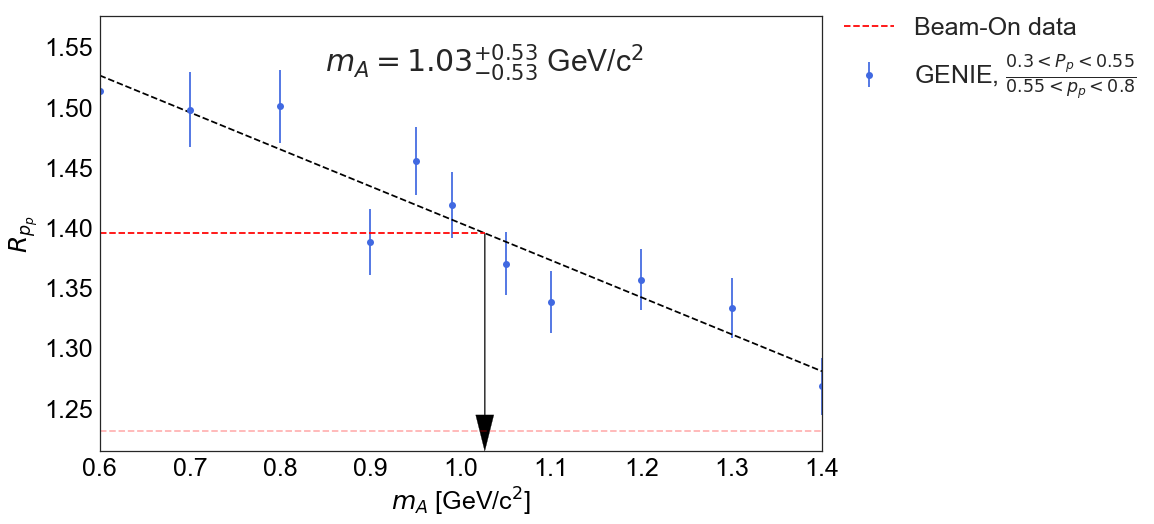

In [122]:

fig,ax=plt.subplots(figsize=(12.944,8))

res = results[Ppmid]
plt.errorbar(x=res['mA'],y=res['R'],yerr=res['R_err'],color='royalblue',fmt='o'
                 ,label=(r'GENIE, $\frac{%.1f<P_p<%.2f}{%.2f<p_p<%.1f}$'%(Pprange[0],Ppmid,Ppmid,Pprange[-1])))    
x,y=res['mA'],res['R']
z=np.polyfit(x,y,deg=1)
poly=np.poly1d(z)
x_poly=linspace(0.6,1.4,100)
plt.plot(x_poly,poly(x_poly),'--',color='black')
    
x_R_BeamOn = find_x_poly(poly,R_BeamOn[Ppmid])
plt.plot([0.6,x_R_BeamOn],[R_BeamOn[Ppmid],R_BeamOn[Ppmid]],'--',color=color,label='Beam-On data')
plt.arrow(x=x_R_BeamOn,y=poly(x_R_BeamOn),dx=0,dy=np.min(ax.get_ylim())+0.015-poly(x_R_BeamOn)
              ,color='black',head_width=0.02,shape='full')

print 'Beam on R,R_err:',R_BeamOn[Ppmid],R_err_BeamOn[Ppmid]
x_R_BeamOn_dw = find_x_poly(poly,R_BeamOn[Ppmid]-R_err_BeamOn[Ppmid]); x_R_BeamOn_up_err = x_R_BeamOn_dw - x_R_BeamOn
x_R_BeamOn_up = find_x_poly(poly,R_BeamOn[Ppmid]+R_err_BeamOn[Ppmid]); x_R_BeamOn_dw_err = x_R_BeamOn - x_R_BeamOn_up
plt.plot([0.6,x_R_BeamOn_dw],[R_BeamOn[Ppmid]-R_err_BeamOn[Ppmid],R_BeamOn[Ppmid]-R_err_BeamOn[Ppmid]],'--'
             ,[0.6,x_R_BeamOn_up],[R_BeamOn[Ppmid]+R_err_BeamOn[Ppmid],R_BeamOn[Ppmid]+R_err_BeamOn[Ppmid]],'--'
             ,color=color,alpha=0.3)


set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$R_{p_p}$',xlim=(0.6,1.4))
plt.text(0.85,1.53,r'$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_R_BeamOn,x_R_BeamOn_up_err,x_R_BeamOn_dw_err),fontsize=30)
plt.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)